In [1]:
from langgraph.graph import StateGraph, MessagesState, START, END  # StateGraph: Defines a graph for stateful workflows; MessagesState: Manages a list of conversation messages; START/END: Constants for graph entry/exit points.
from langgraph.graph.message import add_messages  # add_messages: Appends new messages to the state.
from typing import Annotated, Literal, TypedDict  # Annotated: Adds metadata to type hints for state updates; Literal: Restricts variables to specific literal values; TypedDict: Defines a dictionary with fixed keys and types.
from langchain.tools import tool  # tool: Decorator for functions callable as agent tools.
from langchain_groq import ChatGroq  # ChatGroq: Interface for Groq's language model.
from langchain_core.messages import HumanMessage  # HumanMessage: Represents a user’s input message.
from langgraph.checkpoint.memory import MemorySaver  # MemorySaver: Saves graph state in memory.
from langgraph.prebuilt import ToolNode  # ToolNode: Executes tools and updates state.

from IPython.display import display, Image
def show_image(app):
    try:
        display(Image(app.get_graph().draw_mermaid_png()))
    except Exception as e:
        print(e)

def stream_op(app,input):
    input = {"messages":[input]}
    for output in app.stream(input):
        for key, value in output.items():
            print(f"Output from {key} node.")
            print("========================")
            print(value)
            print()

In [2]:
llm = ChatGroq(model="gemma2-9b-it")

In [3]:
def call_model(state : MessagesState):
    messages = state['messages']
    response = llm.invoke(messages)
    return {'messages' : [response]}

In [4]:
workflow = StateGraph(MessagesState)
workflow.add_node('chatbot',call_model)
workflow.add_edge(START,'chatbot')
workflow.add_edge('chatbot',END)
app = workflow.compile()

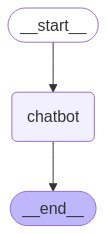

In [5]:
show_image(app)

In [6]:
input = {'messages' : ['Hi, I am DP.']}

In [7]:
app.invoke(input)

{'messages': [HumanMessage(content='Hi, I am DP.', additional_kwargs={}, response_metadata={}, id='04aaa853-89cc-46d4-a24a-c19e624673a7'),
  AIMessage(content="Hello DP, it's nice to meet you!\n\nWhat can I do for you today?\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 15, 'total_tokens': 38, 'completion_time': 0.041818182, 'prompt_time': 0.001933688, 'queue_time': 0.230562141, 'total_time': 0.04375187}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-80caab64-1df3-4020-ae15-906f1221eca9-0', usage_metadata={'input_tokens': 15, 'output_tokens': 23, 'total_tokens': 38})]}

In [8]:
stream_op(app,"hey buddy")

Output from chatbot node.
{'messages': [AIMessage(content='Hey there! 👋  What can I do for you today?\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 11, 'total_tokens': 27, 'completion_time': 0.029090909, 'prompt_time': 0.001949117, 'queue_time': 0.348573371, 'total_time': 0.031040026}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-12d2b0e4-175a-448b-b2b2-ea99eabf85c9-0', usage_metadata={'input_tokens': 11, 'output_tokens': 16, 'total_tokens': 27})]}



In [9]:
@tool 
def search(query: str):
    """this is a custom tool."""
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "its 30 degrees and foggy."
    return "its 28 degrees and sunny."

In [10]:
search.invoke('what is temperature in sf?')

'its 30 degrees and foggy.'

In [11]:
search.invoke('what is temperature in ind?')

'its 28 degrees and sunny.'

In [12]:
search

StructuredTool(name='search', description='this is a custom tool.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001C4FE7B3B00>)

In [13]:
tools = [search]

In [14]:
tool_node = ToolNode(tools)

In [15]:
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'search': StructuredTool(name='search', description='this is a custom tool.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001C4FE7B3B00>)}, tool_to_state_args={'search': {}}, tool_to_store_arg={'search': None}, handle_tool_errors=True, messages_key='messages')

In [16]:
llm_with_tool = llm.bind_tools(tools)

In [17]:
def call_model(state : MessagesState):
    messages = state['messages']
    response = llm_with_tool.invoke(messages)
    return {'messages' : [response]}

In [18]:
response = call_model({"messages" : "Hi, how are you ?"})

In [19]:
response

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qqzx', 'function': {'arguments': '{"query":"How are you?"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 942, 'total_tokens': 1024, 'completion_time': 0.149090909, 'prompt_time': 0.043156078, 'queue_time': 0.2319832, 'total_time': 0.192246987}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-28718628-8a7c-480d-8b8d-d4ce642fa3d5-0', tool_calls=[{'name': 'search', 'args': {'query': 'How are you?'}, 'id': 'call_qqzx', 'type': 'tool_call'}], usage_metadata={'input_tokens': 942, 'output_tokens': 82, 'total_tokens': 1024})]}

In [20]:
messages = response['messages']

In [21]:
last_message = messages[-1]

In [22]:
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'How are you?'},
  'id': 'call_qqzx',
  'type': 'tool_call'}]

In [23]:
response = call_model({"messages" : "What's the weather in taliban ?"})

In [24]:
response['messages'][-1].tool_calls

[{'name': 'search',
  'args': {'query': 'weather in taliban'},
  'id': 'call_kxsf',
  'type': 'tool_call'}]

In [25]:
def router_function(state: MessagesState) -> Literal["tools", END]:
    last_message = state['messages'][-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [26]:
workflow = StateGraph(MessagesState)
workflow.add_node('agent',call_model)
workflow.add_node('tools',tool_node)
workflow.add_edge(START,'agent')
workflow.add_conditional_edges(
    'agent',
    router_function,
    {
        "tools" : "tools",
        END : END
    }
)
app = workflow.compile()

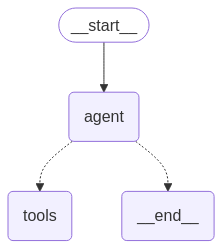

In [27]:
show_image(app)

In [28]:
app.invoke({'messages':['Whats the weather in sf?']})

{'messages': [HumanMessage(content='Whats the weather in sf?', additional_kwargs={}, response_metadata={}, id='dfd753d3-e5b5-4fd2-a16c-7ad8308fb899'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_m7ee', 'function': {'arguments': '{"query":"weather in sf"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 942, 'total_tokens': 1024, 'completion_time': 0.149090909, 'prompt_time': 0.044555557, 'queue_time': 0.23616961700000003, 'total_time': 0.193646466}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-58cbd1e0-871b-45c2-a412-32d96c28874b-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in sf'}, 'id': 'call_m7ee', 'type': 'tool_call'}], usage_metadata={'input_tokens': 942, 'output_tokens': 82, 'total_tokens': 1024}),
  ToolMessage(content='its 30 degrees and foggy.', name='search', id='ec7adf52-36e6-43ac

In [29]:
workflow.add_edge('tools','agent')

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [30]:
app = workflow.compile()

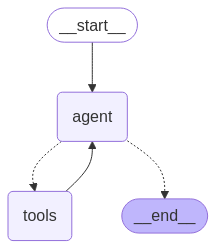

In [31]:
show_image(app)

In [32]:
stream_op(app,"whats temperature in sf?")

Output from agent node.
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_nta6', 'function': {'arguments': '{"query":"temperature in san francisco"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 941, 'total_tokens': 1024, 'completion_time': 0.150909091, 'prompt_time': 0.03314611, 'queue_time': 0.234407629, 'total_time': 0.184055201}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-017650cb-8b89-4383-b96c-1bc262e9ccff-0', tool_calls=[{'name': 'search', 'args': {'query': 'temperature in san francisco'}, 'id': 'call_nta6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 941, 'output_tokens': 83, 'total_tokens': 1024})]}

Output from tools node.
{'messages': [ToolMessage(content='its 30 degrees and foggy.', name='search', id='6a9e9763-6bec-4dc1-ba55-f4220204ff65', tool_call_id='call_nta6')]}

Output

In [33]:
memory = MemorySaver()

In [34]:
workflow = StateGraph(MessagesState)
workflow.add_node('agent',call_model)
workflow.add_node('tools',tool_node)
workflow.add_edge(START,'agent')
workflow.add_conditional_edges(
    'agent',
    router_function,
    {
        "tools" : "tools",
        END : END
    }
)
app = workflow.compile(checkpointer=memory)

In [35]:
config = {
    "configurable" : {
        "thread_id" : "1"
    }
}

In [36]:
events = app.stream({"messages" : ["Hi, I am DP."]}, config=config, stream_mode='values')

In [37]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, I am DP.
================================== Ai Message ==================================
Tool Calls:
  search (call_8sbb)
 Call ID: call_8sbb
  Args:
    query: hi, I am dp
================================= Tool Message =================================
Name: search

its 28 degrees and sunny.


In [38]:
events = app.stream({"messages" : ["Can you tell my name ?"]}, config=config, stream_mode='values')

In [39]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you tell my name ?
================================== Ai Message ==================================

Your name is DP.


In [40]:
memory.get(config)

{'v': 3,
 'ts': '2025-04-18T11:28:49.635886+00:00',
 'id': '1f01c484-c923-65cf-8005-bba20379e48d',
 'channel_versions': {'__start__': '00000000000000000000000000000006.0.08518356329082666',
  'messages': '00000000000000000000000000000007.0.8213542491577601',
  'branch:to:agent': '00000000000000000000000000000007.0.1222910444433023',
  'branch:to:tools': '00000000000000000000000000000004.0.1738282391227325'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000005.0.9795519801760564'},
  'agent': {'branch:to:agent': '00000000000000000000000000000006.0.022688973806106683'},
  'tools': {'branch:to:tools': '00000000000000000000000000000003.0.2909158358734304'}},
 'channel_values': {'messages': [HumanMessage(content='Hi, I am DP.', additional_kwargs={}, response_metadata={}, id='8170eb0a-a723-48ab-922b-84d5f553ae4b'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8sbb', 'function': {'arguments': '{"query":"hi, I am dp"}', 